In [1]:
from sklearn.decomposition import DictionaryLearning

#importando bibliotecas
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from IPython.display import Image
from pathlib import Path


config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_DICT = DIRETORIO_PRINCIPAL / "DICT"
DIRETORIO_DATASET = DIR_PREFIXO / "Projeto_PA"



In [2]:
# Datset com todos os campos: metadados, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv", encoding="Latin1", sep=";")



In [3]:
#Selecionar as que serao utilizadas

def boolParaInt(valor):
    if valor == True:
        return 1
    elif valor == False:
        return 0

dataset_filtrado_tratado = pd.DataFrame()

for coluna in list(dataset.loc[:,'Hipotensao':'Normotenso'].columns):
    dataset_filtrado_tratado[coluna] = dataset.loc[:,coluna].apply(boolParaInt)

dataset_filtrado_tratado
array_filtrado_tratado = np.array(dataset_filtrado_tratado)
#array_numerico

In [4]:
#numero de componentes do Dictionary Learning
num_comp = 7

In [5]:
#parametros da tecnica
dict_learner = DictionaryLearning(n_components=num_comp)

In [6]:
#pegando as variaveis 
x_variaveis = dataset_filtrado_tratado.values

In [7]:
#aplicando o dictionaryLearning
%time X_transformed = dict_learner.fit_transform(x_variaveis)

Wall time: 42.6 s


In [8]:
#resultado
X_transformed

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.72794567,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.72794567,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.18534582,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.73176333, ...,  0.        ,
         0.        ,  0.        ]])

In [9]:
#Funções para calcular com K-Means o melhor numero de cluster(grupos) que seu dataset gerar
def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [10]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(X_transformed)
n = optimal_number_of_clusters(sum_of_squares)
print(n)

7


In [11]:
#habilitando o kmeans com n grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=0).fit(X_transformed)

In [12]:
#lista de grupos 
grupos = kmeans.fit_predict(x_variaveis)

In [13]:
#colocar os grupos gerados apartir do DictionaryLearning
dataset_filtrado_tratado['grupo'] = grupos 
dataset_filtrado_tratado['grupo'] = dataset_filtrado_tratado['grupo'] + 1

In [14]:
dataset_filtrado_tratado

,Hipotensao,Sistolica Isolada,Diastolica Isolada,Dipping,Non Dipping,Extreme Dipping,Reverse Dipping,Morning Surge,Masked,Whitecoat,Normotenso,grupo
0,1,0,0,0,0,0,1,0,0,0,0,7
1,1,0,0,0,0,0,1,0,0,0,0,7
2,1,0,0,0,1,0,0,0,0,1,0,1
3,1,0,0,1,0,0,0,0,0,1,0,6
4,1,0,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
19258,1,0,0,1,0,0,0,1,0,1,0,3
19259,1,0,0,0,1,0,0,0,0,1,0,1
19260,1,0,0,0,1,0,0,0,0,1,0,1
19261,1,0,0,0,0,1,0,0,0,0,0,5


In [15]:
#criar dataframe de contagem
dt_final = pd.concat([dataset.loc[:,:'data_exame'],dataset_filtrado_tratado['grupo'],dataset.loc[:,'sist 9:00':]],axis=1)

In [16]:
dt_final

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,grupo,sist 9:00,...,Mediana Sistolica em 24h,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica
0,4,1923-10-05,1,94.0,85.0,160,33.2,2018-09-10 12:25:23,7,105.0,...,118.5,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34
1,5,1948-10-07,1,70.0,80.0,165,29.4,2018-12-26 07:39:41,7,103.0,...,106.0,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23
2,6,1999-03-23,1,19.0,100.0,197,25.8,2018-12-26 08:06:19,1,147.0,...,133.0,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,2018-12-26 08:19:06,6,140.0,...,131.0,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9
4,8,1990-03-07,1,28.0,120.0,172,40.6,2018-12-26 08:26:59,4,113.0,...,115.0,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19258,21786,1972-11-25,1,47.0,75.0,165,27.5,2020-09-10 16:03:08,3,163.0,...,152.0,116.0,12224.5,9265.0,2439.0,474.5,18.66,14.80,49,60
19259,21787,1970-10-19,1,49.0,90.0,183,26.9,2020-09-10 16:21:02,1,114.0,...,136.0,85.0,10970.0,6819.0,3319.0,738.0,17.22,13.67,32,27
19260,21788,1985-03-15,0,35.0,93.0,167,33.3,2020-09-10 16:44:53,1,107.0,...,112.0,62.0,9245.0,4935.5,3556.0,713.5,14.36,8.29,14,26
19261,21792,1952-04-21,0,68.0,64.0,160,25.0,2020-09-10 17:25:50,5,94.0,...,109.5,68.0,8989.5,5660.0,2815.5,460.0,14.14,9.38,19,13


In [17]:
def gera_arquivos_por_grupo(todos_dados_grupo):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_DICT / f"DICT_approach_doenca_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)

gera_arquivos_por_grupo(dt_final)

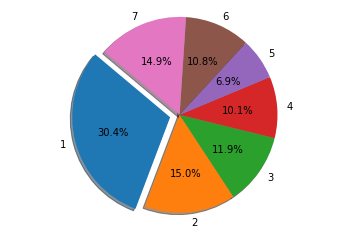

In [36]:
# Dados para o plot
labels = set(dt_final['grupo'])
total = len(dt_final)

sizes = [np.round(len(dt_final[dt_final['grupo'] == x])/total *100,2) for x in labels]

'''ls_itens = list(dt_final['numero_identificacao'])
item = max(ls_itens)
posicao = ls_itens.index(item)

lst_tlp = []
for i in range(0,len(ls_itens)):
    if i == posicao:
        lst_tlp.append(0.1)
    else:
        lst_tlp.append(0)

explode = tuple(lst_tlp) '''

explode = np.zeros(len(labels))
for i in range(len(labels)):
    if sizes[i] == max(sizes):
        explode[i] = 0.1
        break
# Plot
plt.pie(sizes, labels=labels, explode = explode,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()